## Compare track cuts 

Attempts to understand these track parameters

Track cuts 2: 

All loop helix parameter arrays are not the same length, they have all cuts applied except for the parameter of interest. 

In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess

# Process data

In [2]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self, file_name=None, file_list_path=None, defname=None, cuts_to_toggle=None, location=None):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class"s __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        self.file_name = file_name 
        self.defname = defname
        self.file_list_path = file_list_path
        
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = location   # File location
        self.max_workers = 75      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        # Toggle cuts
        self.cuts_to_toggle = cuts_to_toggle 
        
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class"s process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                this_data, 
                file_name,
                cuts_to_toggle = self.cuts_to_toggle
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None



In [3]:
cut_configs = { 
    "no_Rmax" : {
        "within_lhr_max" : False,
        "unvetoed" : False
    }, 
    "no_d0" : {
        "within_d0" : False,
        "unvetoed" : False
    }, 
    "no_tanDip" : {
        "within_pitch_angle" : False,
        "unvetoed" : False
    }
}

In [4]:
onspill = {}
signal = {}

for name, config in cut_configs.items():

    # Execute analysis
    cosmic_processor = CosmicProcessor(
        # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root",
        # defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root",
        file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt",
        location = "disk",
        cuts_to_toggle = config   
    )
        
    onspill_results = cosmic_processor.execute()
    
    cosmic_processor = CosmicProcessor(
        # file_name="/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root",
        # defname = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.root",
        file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt",
        location = "tape",
        cuts_to_toggle = config   
    )
    
    signal_results = cosmic_processor.execute()

    # Initialise postprocessor 
    postprocessor = PostProcess()

    # Execute postprocessor
    onspill[name], _, stats_onspill, _ = postprocessor.execute(onspill_results)
    signal[name], _, stats_signal, _ = postprocessor.execute(signal_results)

    cut_manager = CutManager()
    df_stats_onspill = cut_manager.get_cut_stats(stats=stats_onspill, active_only=True, printout=False)
    df_stats_signal = cut_manager.get_cut_stats(stats=stats_signal, active_only=True, printout=False)

    print()
    print("*"*100)
    print(name)
    display(df_stats_onspill)
    print()
    display(df_stats_signal)
    print("*"*100)
    print()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [00:53<00:00,  1.88file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [00:51<00:00,  1.95file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 1990 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 52596 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 

****************************************************************************************************
no_Rmax


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_reco_electron,True,258586,96.67,96.67,Electron track fits
2,has_trk_front,True,256419,95.86,99.16,Tracks intersect tracker entrance
3,good_trkqual,True,45137,16.87,17.60,Track fit quality > 0.8)
4,within_t0,True,36789,13.75,81.51,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,26331,9.84,71.57,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,26259,9.82,99.73,>= 21 active tracker hits
7,within_d0,True,9414,3.52,35.85,Distance of closest approach (d_0 < 100 mm)
8,within_pitch_angle,True,5175,1.93,54.97,Extrapolated pitch angle (0.557735 < tan(theta...
9,is_truth_electron,True,3248,1.21,62.76,Track parents are electrons (truth PID)


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_reco_electron,True,147225,99.92,99.92,Electron track fits
2,has_trk_front,True,144742,98.24,98.31,Tracks intersect tracker entrance
3,good_trkqual,True,79107,53.69,54.65,Track fit quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,57217,38.83,100.00,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,56804,38.55,99.28,>= 21 active tracker hits
7,within_d0,True,56338,38.24,99.18,Distance of closest approach (d_0 < 100 mm)
8,within_pitch_angle,True,52786,35.83,93.70,Extrapolated pitch angle (0.557735 < tan(theta...
9,is_truth_electron,True,52786,35.83,100.00,Track parents are electrons (truth PID)


****************************************************************************************************

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [00:55<00:00,  1.82file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [00:54<00:00,  1.83file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 3549 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 47178 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 

****************************************************************************************************
no_d0


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_reco_electron,True,258586,96.67,96.67,Electron track fits
2,has_trk_front,True,256419,95.86,99.16,Tracks intersect tracker entrance
3,good_trkqual,True,45137,16.87,17.60,Track fit quality > 0.8)
4,within_t0,True,36789,13.75,81.51,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,26331,9.84,71.57,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,26259,9.82,99.73,>= 21 active tracker hits
7,within_pitch_angle,True,13566,5.07,51.66,Extrapolated pitch angle (0.557735 < tan(theta...
8,within_lhr_max,True,10890,4.07,80.27,Loop helix maximum radius (450 < R_max < 680 mm)
9,is_truth_electron,True,7111,2.66,65.30,Track parents are electrons (truth PID)


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_reco_electron,True,147225,99.92,99.92,Electron track fits
2,has_trk_front,True,144742,98.24,98.31,Tracks intersect tracker entrance
3,good_trkqual,True,79107,53.69,54.65,Track fit quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,57217,38.83,100.00,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,56804,38.55,99.28,>= 21 active tracker hits
7,within_pitch_angle,True,53034,35.99,93.36,Extrapolated pitch angle (0.557735 < tan(theta...
8,within_lhr_max,True,47362,32.14,89.30,Loop helix maximum radius (450 < R_max < 680 mm)
9,is_truth_electron,True,47362,32.14,100.00,Track parents are electrons (truth PID)


****************************************************************************************************

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [01:01<00:00,  1.62file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 75 processes


Processing: 100%|██████████████████████████████| 100/100 [00:55<00:00,  1.80file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 2810 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 48108 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 

****************************************************************************************************
no_tanDip


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_reco_electron,True,258586,96.67,96.67,Electron track fits
2,has_trk_front,True,256419,95.86,99.16,Tracks intersect tracker entrance
3,good_trkqual,True,45137,16.87,17.60,Track fit quality > 0.8)
4,within_t0,True,36789,13.75,81.51,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,26331,9.84,71.57,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,26259,9.82,99.73,>= 21 active tracker hits
7,within_d0,True,9414,3.52,35.85,Distance of closest approach (d_0 < 100 mm)
8,within_lhr_max,True,7393,2.76,78.53,Loop helix maximum radius (450 < R_max < 680 mm)
9,is_truth_electron,True,4802,1.80,64.95,Track parents are electrons (truth PID)


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_reco_electron,True,147225,99.92,99.92,Electron track fits
2,has_trk_front,True,144742,98.24,98.31,Tracks intersect tracker entrance
3,good_trkqual,True,79107,53.69,54.65,Track fit quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)
5,downstream,True,57217,38.83,100.00,Downstream tracks (p_z > 0 at tracker entrance)
6,has_hits,True,56804,38.55,99.28,>= 21 active tracker hits
7,within_d0,True,56338,38.24,99.18,Distance of closest approach (d_0 < 100 mm)
8,within_lhr_max,True,48290,32.77,85.71,Loop helix maximum radius (450 < R_max < 680 mm)
9,is_truth_electron,True,48290,32.77,100.00,Track parents are electrons (truth PID)


****************************************************************************************************



## surface cut 

In [5]:
selector = Select()

# ST_Front = 100, ST_Back, ST_Inner, ST_Outer, ST_Foils, ST_Wires
# // 100–105

def apply_trk_ent_cut(data): 

    # this_data = ak.copy(data)
    
    # Track front 
    at_trk_front = selector.select_surface(data["trkfit"], sid=0) # trksegs-level
    has_trk_front = ak.any(at_trk_front, axis=-1)

    data["trkfit"] = data["trkfit"][at_trk_front]
    
    # # Then clean up events with no tracks after cuts
    data = data[ak.any(has_trk_front, axis=-1)]

    print("Done")

list(set(ak.flatten(onspill["no_Rmax"]["trkfit"]["trksegs"]["sid"], axis=None)))

for _onspill, _signal in zip(onspill.values(), signal.values()):
    # print(_onspill)
    apply_trk_ent_cut(_onspill)
    apply_trk_ent_cut(_signal)
    
list(set(ak.flatten(onspill["no_Rmax"]["trkfit"]["trksegs"]["sid"], axis=None)))

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done


[0]

## Plot

In [6]:
tag = "trk_ent"

In [7]:
plot = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Track cuts summary

In [8]:
vector = Vector()

def calc_pitch_angle(data):

    pvec = vector.get_vector(data["trkfit"]["trksegs"], "mom")
    pt = np.sqrt(pvec["x"]**2 + pvec["y"]**2) # vector.get_vector(signal["trkfit"]["trksegs"], "mom")
    
    p = vector.get_mag(data["trkfit"]["trksegs"], "mom") 
    pz = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]

    cos_theta = pt / p  
    theta = np.arccos(cos_theta)
    tan_theta_check = np.tan(theta)

    tan_theta = pz/pt 

    data["tan_dip"] = tan_theta
    # data["tan_theta_check"] = tan_theta_check
    
for _onspill, _signal in zip(onspill.values(), signal.values()):
    # print(_onspill)
    calc_pitch_angle(_onspill)
    calc_pitch_angle(_signal)

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


In [9]:
print(signal.keys())

dict_keys(['no_Rmax', 'no_d0', 'no_tanDip'])


dict_keys(['no_Rmax', 'no_d0', 'no_tanDip'])


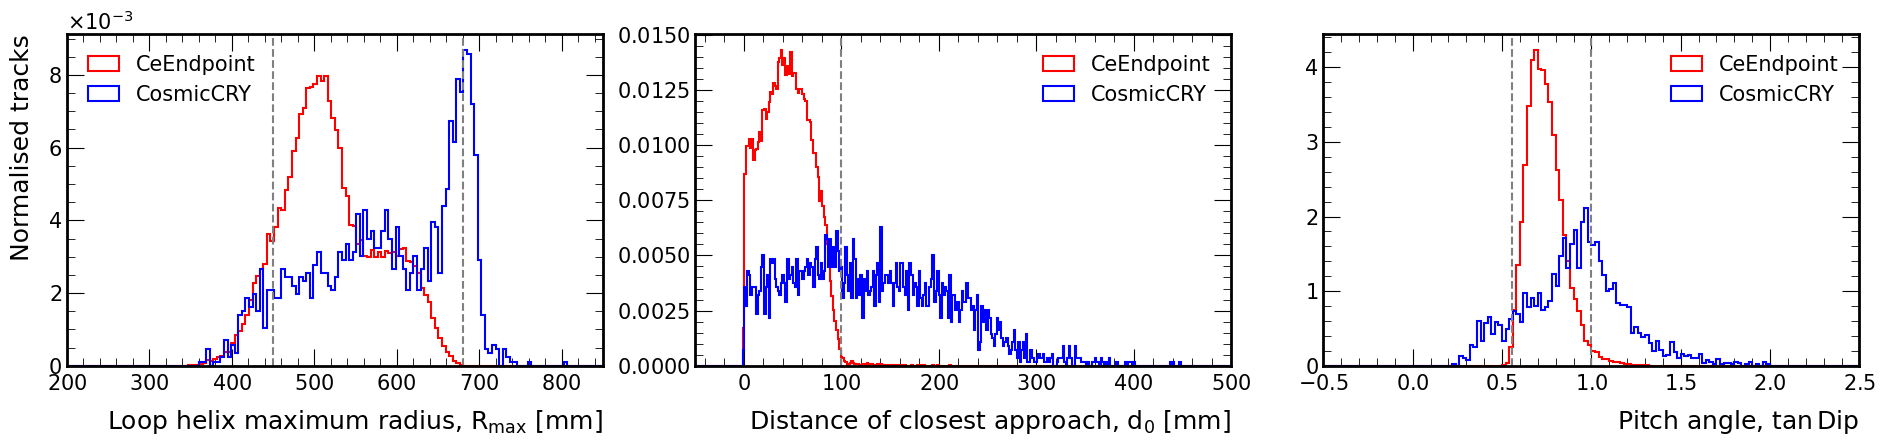

In [10]:
print(signal.keys())

fig, ax = plt.subplots(1, 3, figsize=(6.4*3, 4.8))

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["no_Rmax"]["trkfit"]["trksegpars_lh"]["maxr"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["no_Rmax"]["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
    },
    nbins=75*2,xmin=200,xmax=850,norm_by_area=True,
    show=False,
    ax=ax[0],
    xlabel=r"Loop helix maximum radius, $R_{\text{max}}$ [mm]",
    ylabel="Normalised tracks",
)

ax[0].axvline(450, linestyle="--", color="grey")
ax[0].axvline(680, linestyle="--", color="grey")

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["no_d0"]["trkfit"]["trksegpars_lh"]["d0"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["no_d0"]["trkfit"]["trksegpars_lh"]["d0"], axis=None)
    },
    nbins=350,xmin=-50,xmax=500,norm_by_area=True,
    show=False,
    ax=ax[1],
    xlabel=r"Distance of closest approach, $d_{0}$ [mm]",
    # ylabel="Norm. tracks"
)


ax[1].axvline(100, linestyle="--", color="grey")

plot.plot_1D_overlay(
    {
        "CeEndpoint" : ak.flatten(signal["no_tanDip"]["tan_dip"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["no_tanDip"]["tan_dip"], axis=None)
    },
    nbins=150,xmin=-0.5,xmax=2.5,norm_by_area=True,
    show=False,
    # leg_pos="upper left",
    ax=ax[2],
    xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
    # ylabel="Norm. tracks"
)

ax[2].axvline(0.5577350, linestyle="--", color="grey")
ax[2].axvline(1.0, linestyle="--", color="grey")

plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_track_cuts_summary_2.png", dpi=300)
plt.show()

## Just to get the point across...

dict_keys(['no_Rmax', 'no_d0', 'no_tanDip'])
no_Rmax
no_d0
no_tanDip


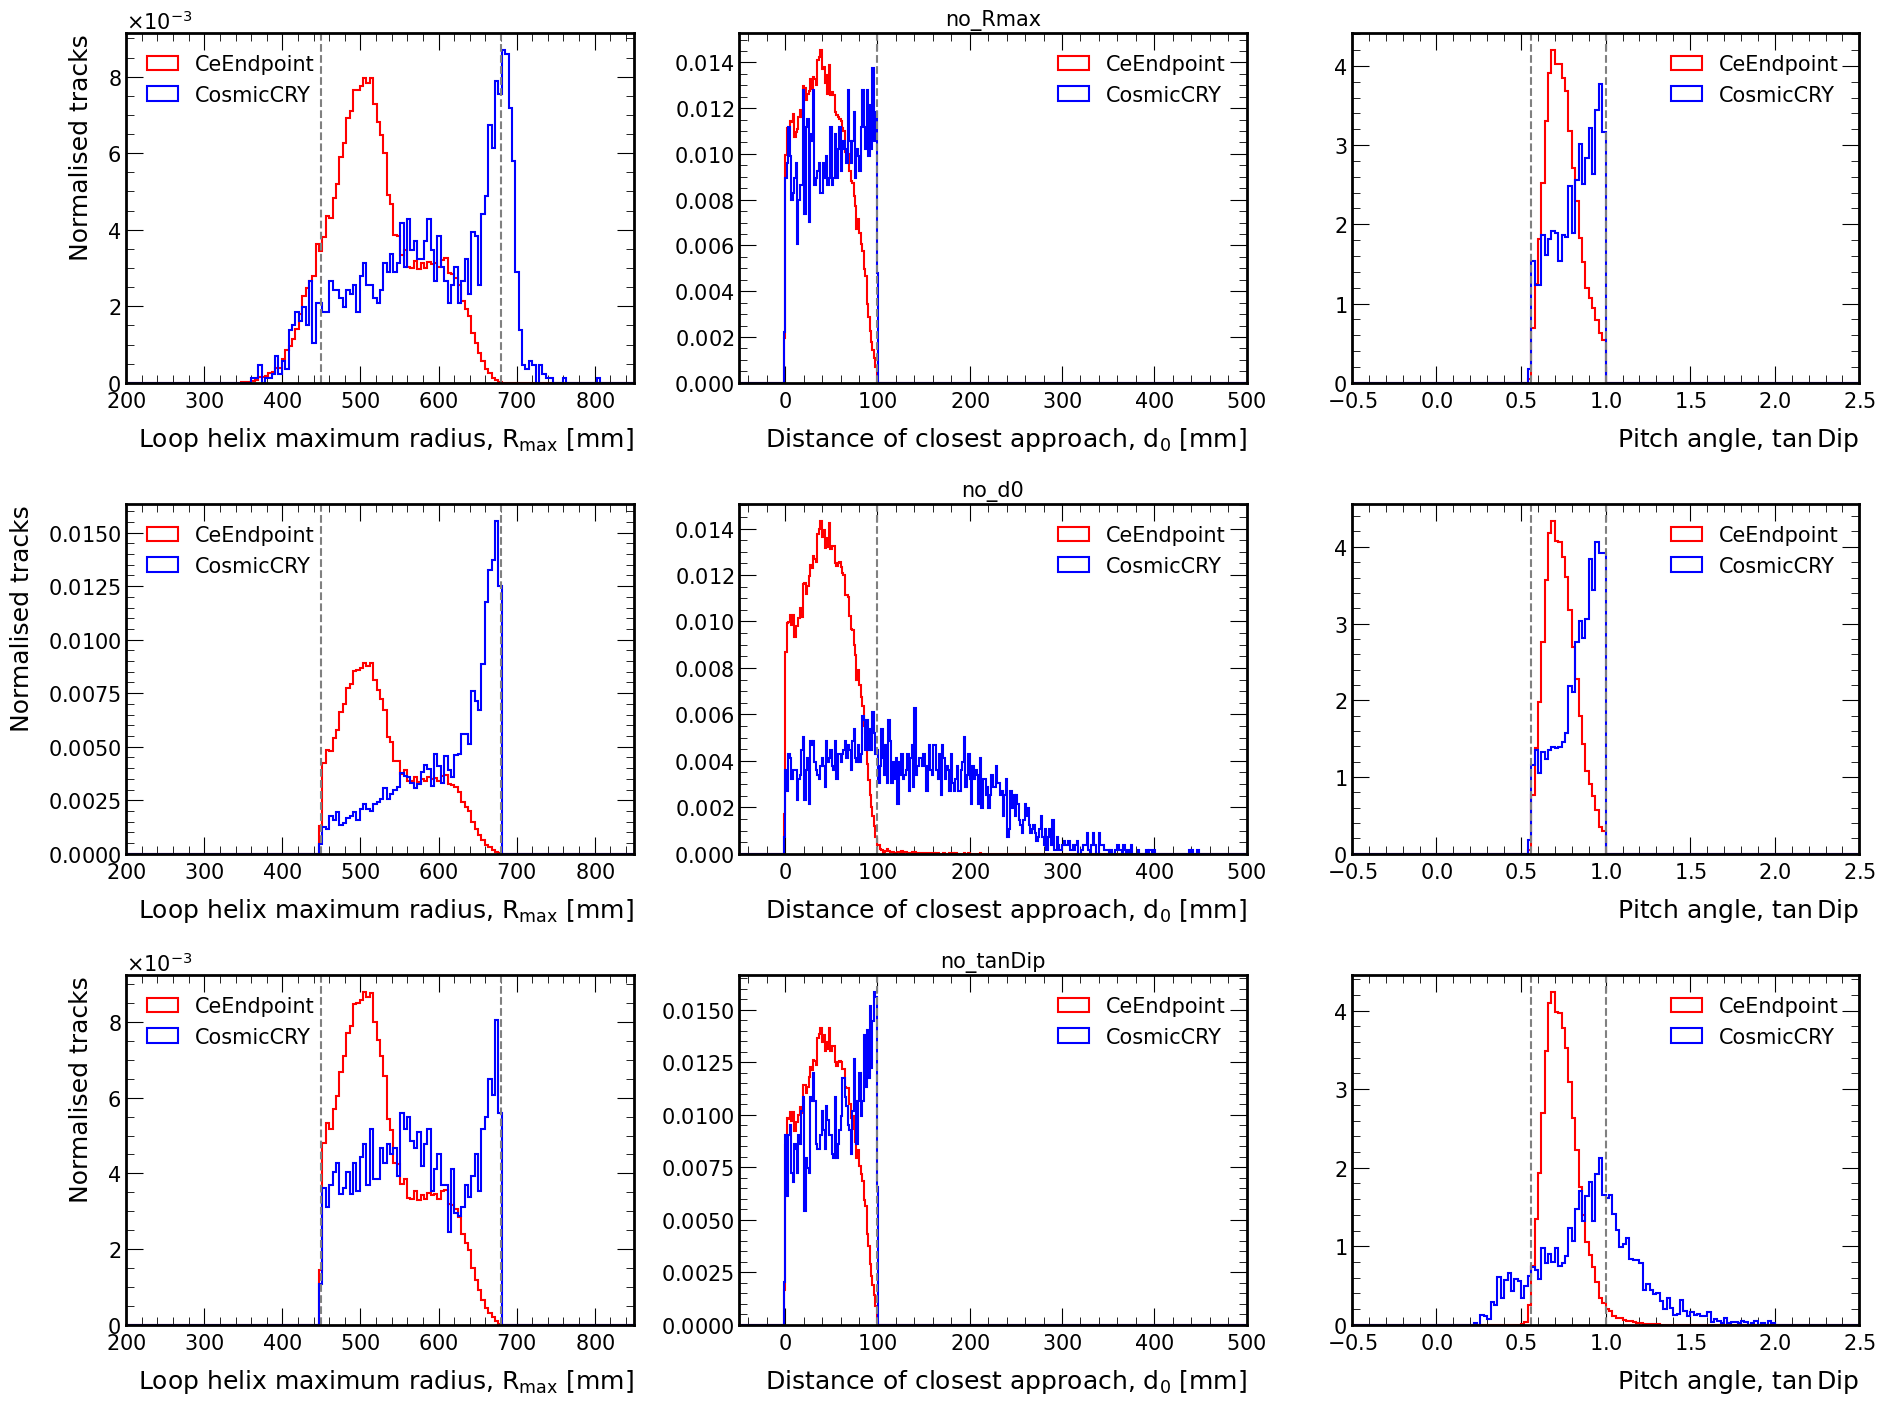

In [11]:
print(signal.keys())

fig, ax = plt.subplots(3, 3, figsize=(6.4*3, 4.8*3))

for i, config in enumerate(signal.keys()): 

    print(config)
    plot.plot_1D_overlay(
        {
            "CeEndpoint" : ak.flatten(signal[config]["trkfit"]["trksegpars_lh"]["maxr"], axis=None), 
            "CosmicCRY" : ak.flatten(onspill[config]["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
        },
        nbins=75*2,xmin=200,xmax=850,norm_by_area=True,
        show=False,
        ax=ax[i, 0],
        xlabel=r"Loop helix maximum radius, $R_{\text{max}}$ [mm]",
        ylabel="Normalised tracks",
        
    )
    
    ax[i, 0].axvline(450, linestyle="--", color="grey")
    ax[i, 0].axvline(680, linestyle="--", color="grey")
    
    plot.plot_1D_overlay(
        {
            "CeEndpoint" : ak.flatten(signal[config]["trkfit"]["trksegpars_lh"]["d0"], axis=None), 
            "CosmicCRY" : ak.flatten(onspill[config]["trkfit"]["trksegpars_lh"]["d0"], axis=None)
        },
        nbins=350,xmin=-50,xmax=500,norm_by_area=True,
        show=False,
        ax=ax[i, 1],
        xlabel=r"Distance of closest approach, $d_{0}$ [mm]",
        title=config
        # ylabel="Norm. tracks"
    )
    
    
    ax[i, 1].axvline(100, linestyle="--", color="grey")
    
    plot.plot_1D_overlay(
        {
            "CeEndpoint" : ak.flatten(signal[config]["tan_dip"], axis=None), 
            "CosmicCRY" : ak.flatten(onspill[config]["tan_dip"], axis=None)
        },
        nbins=150,xmin=-0.5,xmax=2.5,norm_by_area=True,
        show=False,
        # leg_pos="upper left",
        ax=ax[i, 2],
        xlabel=r"Pitch angle, $\tan{\text{Dip}}$",
        # ylabel="Norm. tracks"
    )
    
    ax[i, 2].axvline(0.5577350, linestyle="--", color="grey")
    ax[i, 2].axvline(1.0, linestyle="--", color="grey")

plt.tight_layout()
plt.savefig(f"../../img/comp/h1o_track_cuts_summary_3.png", dpi=300)
plt.show()